In [ ]:
import os
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
# Import Phraser directly from gensim.models.phrases
from gensim.models.phrases import Phrases, Phraser
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install --upgrade gensim

In [ ]:
# Function to preprocess texts using SpaCy and Gensim's bigrams/trigrams
def preprocess_texts(text):
    all_preprocessed_tokens = []  # Store preprocessed tokens for all sentences

    # Split the text into sentences using '.' as delimiter
    for sentence in text.split('.'):
        if sentence.strip():  # Skip empty sentences
            # Tokenize and remove punctuation
            tokens = [token.text.lower() for token in nlp(sentence) if not token.is_punct]

            # Build bigram and trigram models
            bigram = Phrases([tokens], min_count=5, threshold=100)
            trigram = Phrases(bigram[[tokens]], threshold=100)
            bigram_mod = Phraser(bigram)
            trigram_mod = Phraser(trigram)

            # Apply bigrams and trigrams
            tokens = bigram_mod[tokens]
            tokens = trigram_mod[tokens]

            # Lemmatization and filtering stopwords
            lemmatized_tokens = [
                token.lemma_ for token in nlp(" ".join(tokens))
                if token.lemma_ not in stop_words and len(token.lemma_) > 2
            ]

            all_preprocessed_tokens.append(lemmatized_tokens)  # Store tokens for this sentence

    return all_preprocessed_tokens  # List of tokenized sentences

In [ ]:
# Function to display top words for each topic
def get_topic_words(lda_model, feature_names, num_words=5):
    topic_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topic_words.append(top_words)
    return topic_words

In [ ]:
# Function to perform LDA with hyperparameter tuning
def perform_lda(texts):
    # Convert preprocessed texts to a single string per document
    texts_combined = [" ".join(sentence) for sentence in texts]

    # Create document-term matrix using CountVectorizer
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts_combined)

    # Hyperparameter tuning using GridSearchCV
    search_params = {'n_components': list(range(2, 40, 3)), 'learning_decay': [0.5, 0.7, 0.9]}
    lda = LatentDirichletAllocation(max_iter=10, learning_method='online', random_state=42)

    # Perform grid search to find the best model
    model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)
    model.fit(dtm)

    # Get the best model and optimal number of topics
    best_lda_model = model.best_estimator_
    optimal_num_topics = best_lda_model.n_components
    print(f"Optimal number of topics: {optimal_num_topics}")

    # Get feature names (words) for each topic
    feature_names = vectorizer.get_feature_names_out()

    # Display top words for each topic
    topic_words = get_topic_words(best_lda_model, feature_names, 10)
    for idx, words in enumerate(topic_words):
        print(f"Topic {idx}: {words}")

    # Plot word cloud for each topic
    plot_wordcloud(best_lda_model, optimal_num_topics, feature_names)

    # Return the trained LDA model and topic distribution for further use
    return best_lda_model, best_lda_model.transform(dtm)

In [ ]:
# Function to generate word clouds for topics
def plot_wordcloud(lda_model, num_topics, feature_names, num_words=10):
    for topic_idx, topic in enumerate(lda_model.components_):
        word_freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-num_words - 1:-1]}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)

        # Plot word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_idx + 1} WordCloud", fontsize=15)
        plt.show()

Optimal number of topics: 2
Topic 0: ['boy', 'hero', 'hit', 'guy', 'want', 'great', 'dream', 'baby', 'god', 'yeah']
Topic 1: ['pain', 'know', 'look', 'like', 'pegasus', 'hey', 'baby', 'kid', 'god', 'little']


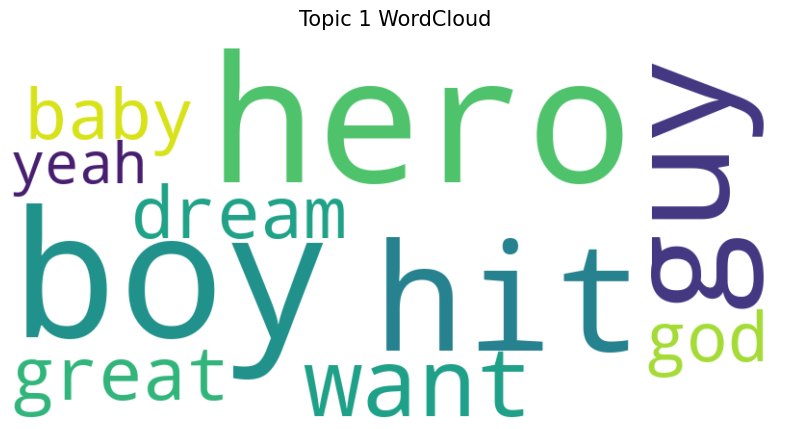

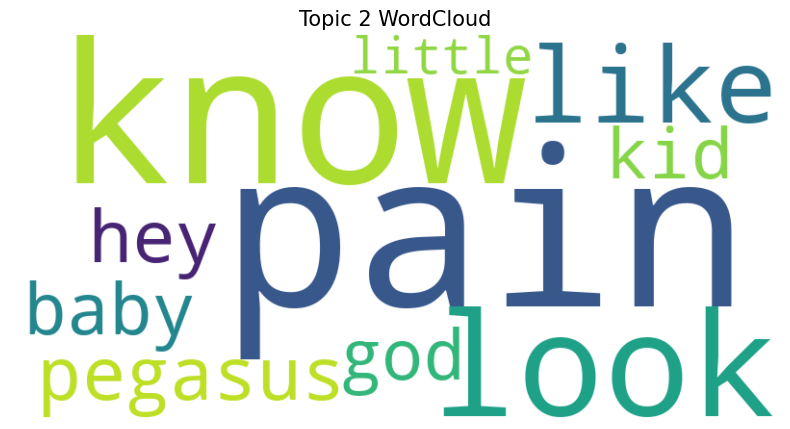

In [ ]:
# Example usage for a movie's text
with open('Hercules.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Preprocess the text and perform LDA
texts_preprocessed = preprocess_texts(text)
lda_model, topic_distribution = perform_lda(texts_preprocessed)